## Correlation analysis:

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import plotly.plotly as py
from plotly.graph_objs import *

##### Data loading:
We load accidents, temperature and wind datasets

In [11]:
df_accidents = pd.read_excel('../data/accidents/df_accidents.xlsx')
df_tmp = pd.read_excel('../data/df_tmp.xlsx')
df_wind = pd.read_excel('../data/df_wind.xlsx')

##### Data cleaning:
- some dates were replaced by NaT => retrieve dates for every sample
- drop duplicates when two avalanche reports were written the same day: we decided to keep only the first one

In [12]:
# remove NaT and replace with the right date
for i in range(0,4):
    index_NaT = df_tmp[df_tmp['date'].isnull()].index.values
    df_tmp.loc[index_NaT,'date'] = df_tmp.loc[index_NaT-1,'date'].values
    
df_tmp = df_tmp.drop_duplicates(subset=['date','region'], keep='first')#.set_index(['date','region'])

# remove NaT and replace with the right date
for i in range(0,4):
    index_NaT = df_wind[df_wind['date'].isnull()].index.values
    df_wind.loc[index_NaT,'date'] = df_wind.loc[index_NaT-1,'date'].values

df_wind = df_wind.drop_duplicates(subset=['date','region'], keep='first')#.set_index(['date','region'])

### Temperature and wind processing:

#### 1: Associate each temperature with avalanche accidents data

In [13]:
# obtain accidents dates
accident_dates = df_accidents.Date.tolist()

# keep temperature dates corresponding to accidents dates
temp_dates = df_tmp[df_tmp['date'].apply(lambda x: x in accident_dates)][['date','temperature']]
temp_dates = temp_dates.drop_duplicates(subset=['date'], keep='first')
df_accidents = df_accidents.rename(columns = {'Date':'date'})
df_accidents = pd.merge(df_accidents,temp_dates,how = 'outer', on = 'date')

mean_temp_gradient = 0.6
df_accidents.temperature = df_accidents.temperature + ((2000 - df_accidents.Elevation) / 100)*mean_temp_gradient
df_accidents.tail()

# TODO: 
# - include location information to select temperatures

,date,Canton,Starting zone,Elevation,Aspect,Activity,Danger level,caught,buried,killed,Latitude,Longitude,temperature
345,2017-02-04,VS,Binn,2300,S,Backcountry touring,3.0,3,1.0,1,46.342085,8.207786,-2.800
346,2017-02-05,VS,Ried-Brig,2205,NNE,Backcountry touring,3.0,1,NaN,1,46.283985,8.066959,-5.230
347,2017-02-22,VS,Leukerbad,3590,S,Backcountry touring,2.0,1,1.0,1,46.423847,7.690221,-7.540
348,2017-03-02,GR,Obersaxen Mundaun,2273,N,Off-piste skiing,3.0,2,1.0,1,46.708793,9.103164,-3.638
349,2017-09-21,BE,Grindelwald,3390,E,Backcountry touring,NaN,2,NaN,1,46.571666,8.008533,NaN


In [14]:
coverage = (len(df_accidents[~np.isnan(df_accidents['temperature'])])/len(df_accidents[[i.year>2001 for i in df_accidents['date']]]))*100
print('Approximately %d percent of avalanche accidents are associated with their temperature' %coverage)

Approximately 81 percent of avalanche accidents are associated with their temperature


#### 2: Associate wind information with avalanche accidents data

In [15]:
wind_dates = df_wind[df_wind['date'].apply(lambda x: x in accident_dates)][['date','wind']]
wind_dates.drop_duplicates(subset=['date'],keep= 'first')
# Add wind to the accidents dataframe
df_accidents = pd.merge(df_accidents, wind_dates, how = 'outer', on = 'date')
df_accidents.tail()

,date,Canton,Starting zone,Elevation,Aspect,Activity,Danger level,caught,buried,killed,Latitude,Longitude,temperature,wind
386,2017-02-22,VS,Leukerbad,3590,S,Backcountry touring,2.0,1,1.0,1,46.423847,7.690221,-7.540,fort
387,2017-02-22,VS,Leukerbad,3590,S,Backcountry touring,2.0,1,1.0,1,46.423847,7.690221,-7.540,faible
388,2017-03-02,GR,Obersaxen Mundaun,2273,N,Off-piste skiing,3.0,2,1.0,1,46.708793,9.103164,-3.638,faible
389,2017-03-02,GR,Obersaxen Mundaun,2273,N,Off-piste skiing,3.0,2,1.0,1,46.708793,9.103164,-3.638,fort
390,2017-09-21,BE,Grindelwald,3390,E,Backcountry touring,NaN,2,NaN,1,46.571666,8.008533,NaN,NaN


In [16]:
coverage = (len(df_accidents[~pd.isnull(df_accidents['wind'])])/len(df_accidents[[i.year>2001 for i in df_accidents['date']]]))*100
print('Approximately %d percent of avalanche accidents are associated with their wind information' %coverage)

Approximately 70 percent of avalanche accidents are associated with their wind information


### Accidents analysis:

On the news or article: "Considering avalanche accidents, this is the deadliest year recorded in this canton !!!"

It could be interested to check if wether or not this is true.

In [17]:
df_accidents['year'] = df_accidents.date.apply(lambda d: d.year)

data = []
for canton in df_accidents['Canton'].unique():
    trace = Bar(
                x = df_accidents['year'].unique(),
                y = df_accidents[df_accidents['Canton']== canton].groupby(by='year')['date'].count(),
                name = canton
                )
    data.append(trace)

layout = Layout(title="Number of avalanches accidents per year",
                xaxis=dict(title='Year'),
                yaxis=dict(title='Count'), 
                barmode = 'stack')
fig = Figure(data=data, layout = layout)
py.iplot(fig, filename='styled_bar_2')

Tendancy: small increase in avalanche accidents along time. This can be due to the fact that backcountry touring and offpiste skiing has become more popular, resulting in an increase in people being at risk to be caught in avalanche.

Another interesting feature is the month in which most accidents are likely to happen.

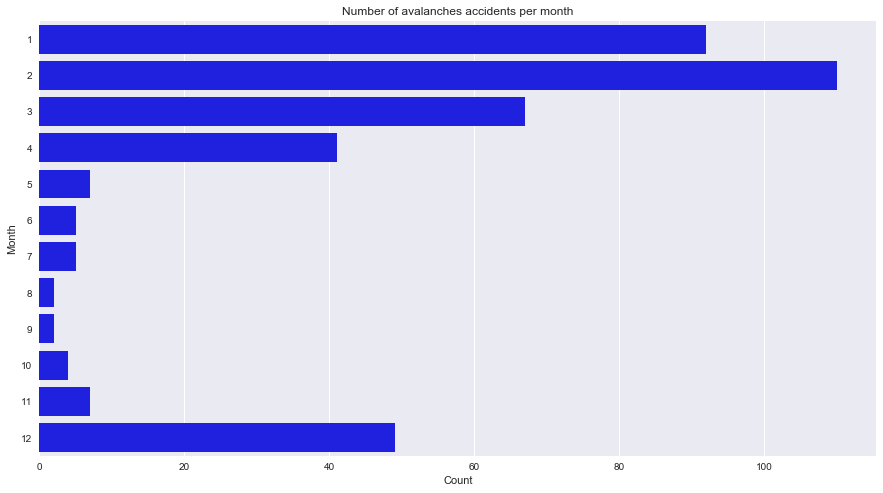

In [18]:
fig, ax = plt.subplots(1, sharey=True, figsize = (15,8));

df_accidents['month'] = df_accidents.date.apply(lambda d: d.month)
sns.countplot(y="month", data=df_accidents, color = 'blue', ax=ax); #order = df_accidents['Aspect'].value_counts().index);
ax.set_title('Number of avalanches accidents per month');
ax.set_xlabel('Count');
ax.set_ylabel('Month');

Most of accidents are happening in january and february

#### 1: Influence of elevation

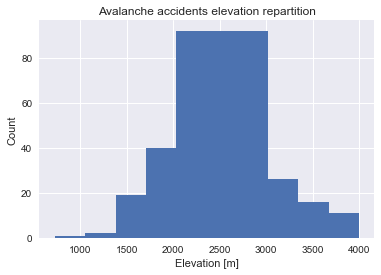

In [19]:
fig, ax = plt.subplots(1, sharey=True);

df_accidents.Elevation.hist(ax =ax)
ax.set_title('Avalanche accidents elevation repartition');
ax.set_xlabel('Elevation [m]');
ax.set_ylabel('Count');

#### 2: Aspect analysis

find aspects found more often

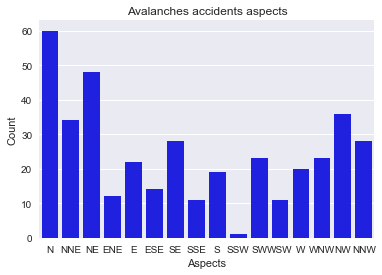

In [20]:
order = ['N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW','W','WNW','NW','NNW']

fig, ax = plt.subplots(1, sharey=True);
sns.countplot(x="Aspect", data=df_accidents, ax=ax, color = 'blue', order = order);
ax.set_title('Avalanches accidents aspects');
ax.set_xlabel('Aspects');
ax.set_ylabel('Count');

correlate aspects with time of year (for example south aspect correlated with spring avalanches)

In [23]:
start_date = [9, 0, 3]
end_date = [12, 3, 6]
vec_season = ['start','middle','end']
ratio = ['start_ratio','middle_ratio','end_ratio']
name = ['start of season','middle of season','end of season']

def get_ratio (start_date, end_date):
        
    mask = [(date.month > start_date) & (date.month <= end_date) for date in df_accidents['date']]
    total = df_accidents[mask]['Aspect'].value_counts().sum()
    aspect_ratio = (df_accidents[mask]['Aspect'].value_counts() / total)*100
    aspect_ratio = aspect_ratio.reset_index()
    aspect_ratio.columns = ['Aspect','Ratio']
    
    return aspect_ratio

In [29]:
for season_time in range(0,3):
    aspect_ratio = get_ratio(start_date[season_time],end_date[season_time])
    exec("aspect_ratio%d = aspect_ratio" % (season_time))

aspect_ratio_final = aspect_ratio.merge(aspect_ratio0.merge(aspect_ratio1, on = 'Aspect', how = 'outer'), on = 'Aspect', how = 'outer')
aspect_ratio_final.columns = ['Aspect','end_ratio','start_ratio','middle_ratio']
aspect_ratio_final = aspect_ratio_final.set_index('Aspect').reindex(order) 

data = []
for r in range(3):
    trace = Bar(
                x = aspect_ratio_final.index.values,
                y = aspect_ratio_final[ratio[r]],
                name = name[r])
    data.append(trace)

layout = Layout(title="Frequency of avalanche accidents per aspect",
                xaxis=dict(title='Aspect'),
                yaxis=dict(title='Frequency'), 
                )
fig = Figure(data=data, layout = layout)
py.iplot(fig, filename='styled_bar')

We can see that considering south aspect accidents, most of them are at the end of the season

####  3: Activity analysis
Which activity is more dangerous ?

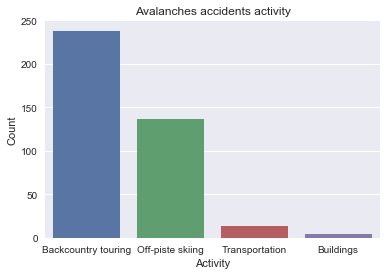

In [104]:
fig, ax = plt.subplots(1, sharey=True);

sns.countplot(x="Activity", data=df_accidents, ax=ax);
ax.set_title('Avalanches accidents activity');
ax.set_xlabel('Activity');
ax.set_ylabel('Count');

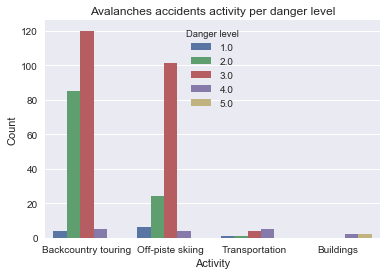

In [118]:
fig, ax = plt.subplots(1, sharey=True);

sns.countplot(x="Activity", hue = 'Danger level', data=df_accidents, ax=ax);
ax.set_title('Avalanches accidents activity per danger level');
ax.set_xlabel('Activity');
ax.set_ylabel('Count');

This graph shows the behaviour of skiiers depend on the activity they are doing.
We see that people doing backcountry touring take less risk than people doing off-piste skiing.

#### 4: Season time analysis:
Does most of accidents related to specific dates in year (for example beginning or end of ski season) ?

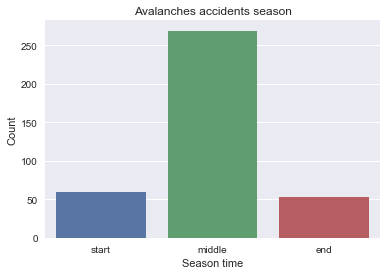

In [103]:
fig, ax = plt.subplots(1);

sns.countplot(x="season", data=df_accidents, ax=ax);
ax.set_title('Avalanches accidents season');
ax.set_xlabel('Season time');
ax.set_ylabel('Count');

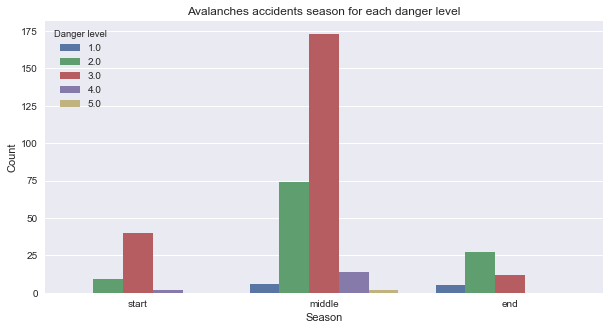

In [241]:
fig, ax = plt.subplots(1, figsize = (10,5));

sns.countplot(x="season", hue = 'Danger level', data=df_accidents, ax=ax);
ax.set_title('Avalanches accidents season for each danger level');
ax.set_xlabel('Season');
ax.set_ylabel('Count');

#### 5: Mortality analysis:
mortality correlation with danger levels.
Mortality = number killed / number caught

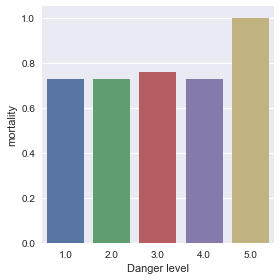

In [108]:
df_accidents['mortality'] = df_accidents['killed']/df_accidents['caught']
survival_rate = df_accidents.groupby(['Danger level']).mean()[['killed','mortality']]
survival_rate = survival_rate.reset_index()
survival_rate.columns = ['Danger level','killed','mortality']
sns.factorplot(data = survival_rate, x= 'Danger level', y='mortality', kind="bar");

#### Correlation Coefficients:

In [251]:
labels = ['feature of interest', 'correlation with rank (pearson)','correlation with rank (spearman)','correlation with rank (kendall)']
interest_range_top = ['temperature','year','Elevation']
corr_danger = {'feature of interest':[], 
                'correlation with rank (pearson)':[],
                'correlation with rank (spearman)':[],
                'correlation with rank (kendall)':[]}
corr_type = ['pearson', 'spearman','kendall']

for ir in interest_range_top:
    corr_danger['feature of interest'].append(ir)
    for c in corr_type:
        corr_danger['correlation with rank ('+str(c)+')'].append(df_accidents['Danger level'].corr(df_accidents[ir], method=str(c)))

#putting the information into dataframes and making sure the order is right        
corr_danger_df = pd.DataFrame(corr_danger)
corr_danger_df = corr_danger_df[labels] 

In [252]:
corr_danger_df

,feature of interest,correlation with rank (pearson),correlation with rank (spearman),correlation with rank (kendall)
0,temperature,-0.113327,-0.076135,-0.059540
1,year,-0.095868,-0.056507,-0.046717
2,Elevation,-0.201048,-0.209657,-0.167929
